In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import re
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV



In [18]:
# nltk.download('stopwords')

# nltk.download('punkt')

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\carly\AppData\Roaming\nltk_data...


True

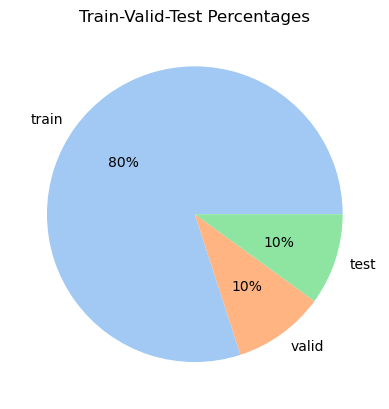

Train size: 40000
Valid size: 5000
Test size: 5000


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [12]:
train_df = pd.read_csv('data/train.csv')
valid_df = pd.read_csv('data/valid.csv')
test_df = pd.read_csv('data/test.csv')

sizes = [len(train_df), len(valid_df), len(test_df)]
names = ['train','valid','test']
colors = sns.color_palette('pastel')[0:3]

fig0 = plt.pie(sizes, labels = names, autopct='%.0f%%', colors=colors)
plt.title('Train-Valid-Test Percentages')
plt.show()

print('Train size: {0}'.format(len(train_df)))
print('Valid size: {0}'.format(len(valid_df)))
print('Test size: {0}'.format(len(test_df)))


train_df.head(5)

## Pre-Processing

#### Remove Stopwords & Lemmatization

In [19]:
stopwords_list = stopwords.words('English')
def remove_stopwords(text, stopwords=stopwords_list):
    # remove stopwords
    processed_text = " ".join(word for word in text.split()
                             if word.lower() not in stopwords)
    # also remove special characters/numbers
    processed_text = re.sub('[^a-zA-Z]+', ' ', processed_text)
    return processed_text

def lemmatize(text, lemmatizer=WordNetLemmatizer()):
    tokens = nltk.word_tokenize(text)
    lemmatized_text = " ".join([lemmatizer.lemmatize(t) for t in tokens])
    return lemmatized_text


def preprocess(text):
    processed_txt = text
    processed_txt = remove_stopwords(processed_txt)
    processed_txt = lemmatize(processed_txt)
    return processed_txt


# apply preprocess procedure
train_df['text'] = train_df['text'].apply(lambda x: preprocess(x))
valid_df['text'] = valid_df['text'].apply(lambda x: preprocess(x))
test_df['text'] = test_df['text'].apply(lambda x: preprocess(x))


#### Maximum Word Count

In [22]:
print('Maximum text length for train:{0}'.format(train_df['text'].apply(lambda x: len(x.split(' '))).max()))
print('Maximum text length for valid:{0}'.format(valid_df['text'].apply(lambda x: len(x.split(' '))).max()))
print('Maximum text length for test:{0}'.format(test_df['text'].apply(lambda x: len(x.split(' '))).max()))


Maximum text length for train:1508
Maximum text length for valid:950
Maximum text length for test:1281


#### TF-IDF Representation

In [33]:
# next, transform  text data into tf-idf format
vectorizer = TfidfVectorizer(max_features=10000, sublinear_tf=True, use_idf=True)

train_vec = vectorizer.fit_transform(train_df['text'])
valid_vec = vectorizer.transform(valid_df['text'])
test_vec = vectorizer.transform(test_df['text'])

train_vec.shape

(40000, 10000)

## Visualization

In [25]:
pos_df = train_df[train_df.label==1]
neg_df = train_df[train_df.label==0]

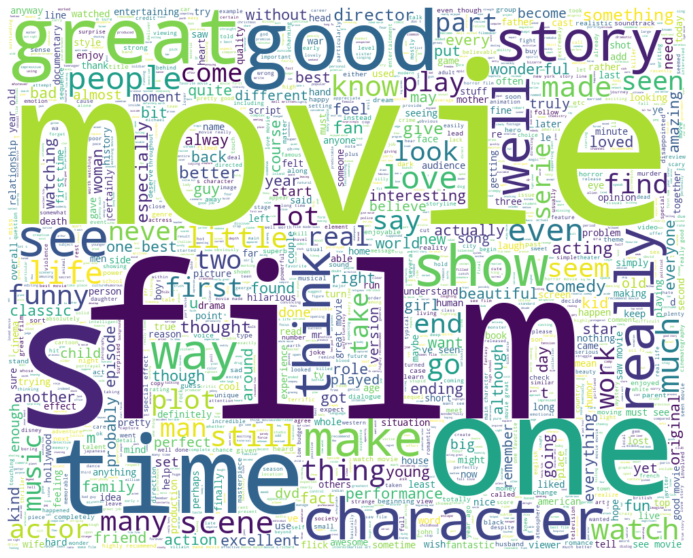

In [96]:
pos_word_list = [t.lower() for t in pos_df['text'] if 'br' not in t]

pos_words = ' '.join([text for text in pos_word_list])
wordcloud = WordCloud(width=1000, height=800, random_state=20, max_words=2000,
                      background_color='white').generate(pos_words)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

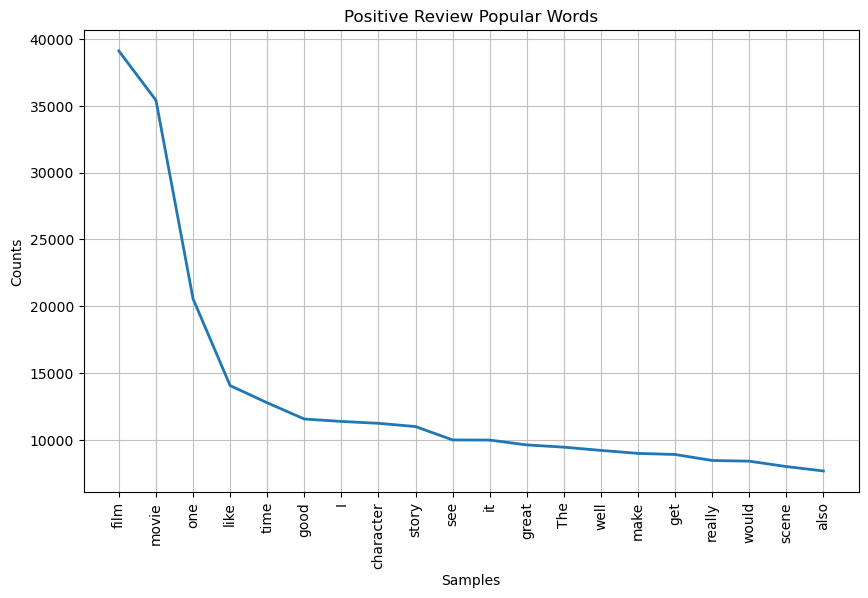

<AxesSubplot: title={'center': 'Positive Review Popular Words'}, xlabel='Samples', ylabel='Counts'>

In [44]:
pos_freq = FreqDist(' '.join(pos_df.text).split(' '))
# drop meaningless words
pos_freq.pop('br')
pos_freq.pop('s')

plt.figure(figsize=(10,6))
pos_freq.plot(20, cumulative=False,title='Positive Review Popular Words')

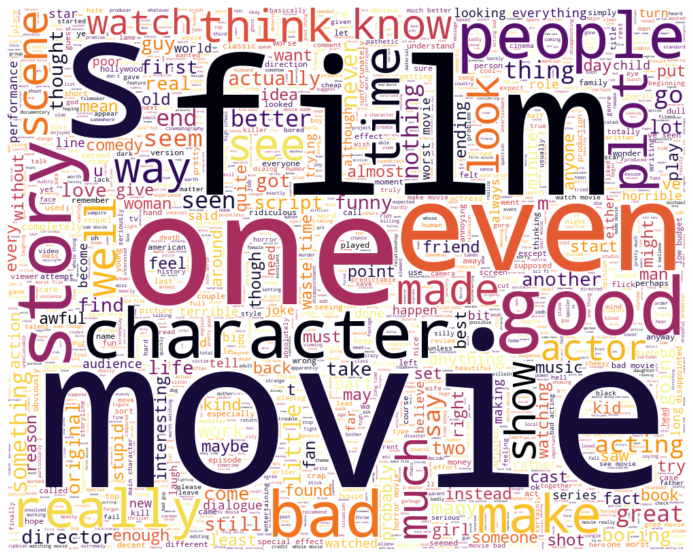

In [95]:
neg_word_list = [t.lower() for t in neg_df['text'] if 'br' not in t]

neg_words = ' '.join([text for text in neg_word_list])
wordcloud = WordCloud(width=1000, height=800, random_state=20, max_words=2000,
                      background_color='white', colormap='inferno').generate(neg_words)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()



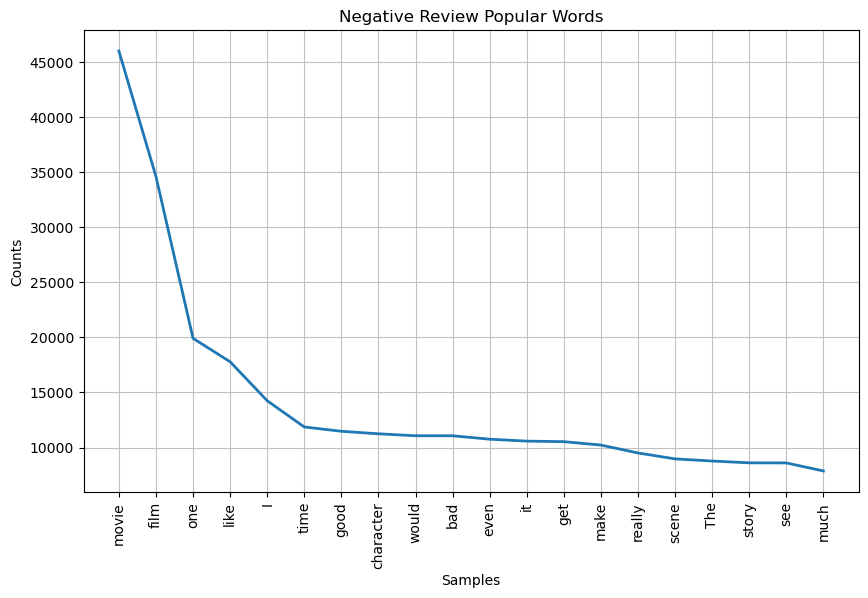

<AxesSubplot: title={'center': 'Negative Review Popular Words'}, xlabel='Samples', ylabel='Counts'>

In [46]:
pos_freq = FreqDist(' '.join(neg_df.text).split(' '))
# drop meaningless words
pos_freq.pop('br')
pos_freq.pop('s')

plt.figure(figsize=(10,6))
pos_freq.plot(20, cumulative=False,title='Negative Review Popular Words')

C:\Users\carly\AppData\Local\Temp\ipykernel_2736\2356770278.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pos_word_count, hist=True)
C:\Users\carly\AppData\Local\Temp\ipykernel_2736\2356770278.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(neg_word_count, hist=True)


Text(0, 0.5, 'Frequency')

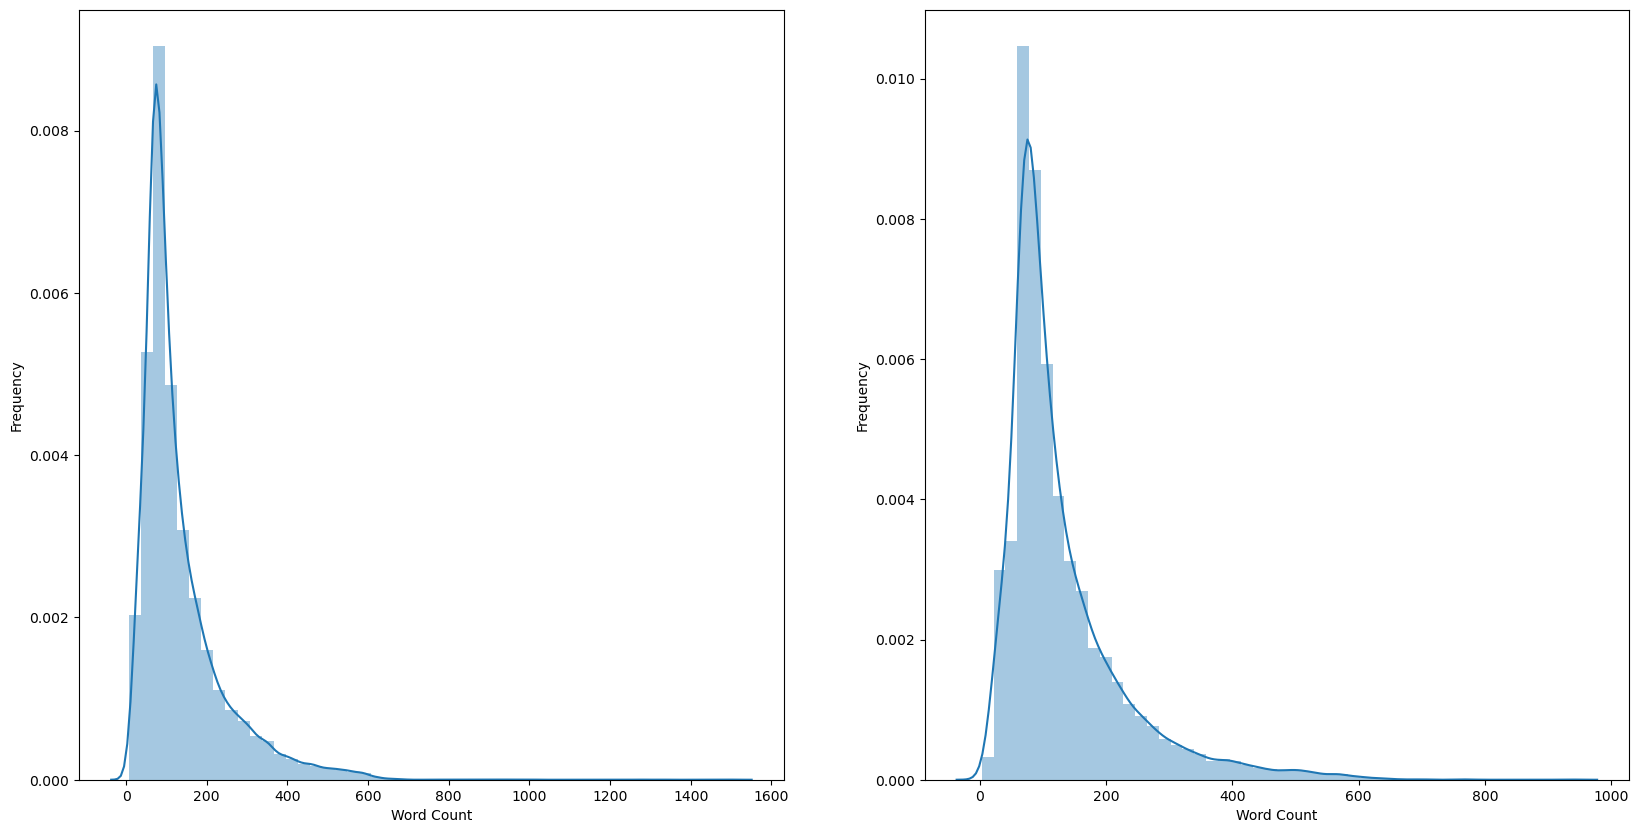

In [60]:
pos_word_count = pos_df.text.apply(lambda x: len(x.split(' ')))
neg_word_count = neg_df.text.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(20,10))

plt.subplot(121)
sns.distplot(pos_word_count, hist=True)
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.subplot(122)
sns.distplot(neg_word_count, hist=True)
plt.xlabel("Word Count")
plt.ylabel("Frequency")

## Support Vector Machine

In [124]:
SVM_classifier = svm.SVC(kernel='linear')

# train the classifier
SVM_classifier.fit(X=train_vec, y=train_df.label)

# make prediction based on test.csv
pred_labels_svm = SVM_classifier.predict(test_vec)

# evaluate classification outcome
svm_report = classification_report(y_true = test_df.label, y_pred = pred_labels_svm,
                                   target_names=['negative','positive'])
print(svm_report)


              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      2495
    positive       0.88      0.90      0.89      2505

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



Text(0.5, 15.0, 'Predicted Label')

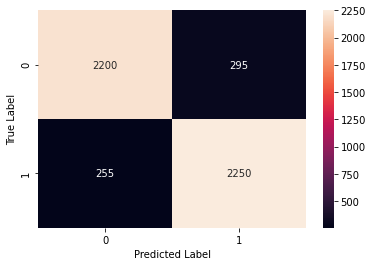

In [125]:
cm_svm = confusion_matrix(test_df['label'], pred_labels_svm)

sns.heatmap(cm_svm, annot=True, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

## XG-Boost

In [63]:
xgb_classifier = xgb.XGBClassifier()

# train the classifier
xgb_classifier.fit(X=train_vec, y=train_df.label)

# make prediction based on test.csv
pred_labels_xgb = xgb_classifier.predict(test_vec)

# evaluate classification outcome
xgb_report = classification_report(y_true = test_df.label, y_pred = pred_labels_xgb,
                                   target_names=['negative','positive'])
print(xgb_report)


              precision    recall  f1-score   support

    negative       0.87      0.83      0.85      2495
    positive       0.84      0.87      0.86      2505

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



## Hyperparameter Grid Search: XG-Boost

In [66]:
# parameter grid
# reference: https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390

# learning rate: how quickly residual errors are fit by base learners
lr_grid = [0.01, 0.05, 0.1, 0.2]

# maximum depth of tree nodes
max_depth_grid = np.arange(3,10)

# fraction of training data used to train each tree
subsample_grid = [0.5, 0.6, 0.7, 0.8]

# fraction of features used to train each tree
colsample_bytree_grid = [0.5, 0.6, 0.7, 0.8]

# Minimum loss reduction required to make a further partition on a leaf node of the tree;
# the higher, the more conservative
gamma_grid = [0, 0.2, 0.4]

# L-1 regularization term on weights; the higher, the more conservative (stronger regularization)
reg_alpha_grid = [0, 0.5, 1]

# L-2 regularization term on weights; the higher, the more conservative (stronger regularization)
reg_lambda_grid = [0, 0.5, 1]





# parameter grids
xgb_param_grid = {
    'eta': lr_grid, 
    'max_depth': max_depth_grid,
    'subsample': subsample_grid, 
    'colsample_bytree': colsample_bytree_grid,
    'gamma': gamma_grid,
    'reg_alpha': reg_alpha_grid,
    'reg_lambda': reg_lambda_grid
}

xgb_0 = xgb.XGBClassifier()
random_cv = RandomizedSearchCV(
    xgb_0, 
    xgb_param_grid, 
    n_iter=100, 
    cv=3, 
    scoring="f1", 
    n_jobs=-1 # use n_jobs=-1 to use all processor cores
)


In [67]:
# number of possible iterations if run complete grid search
n_iter = 1
for val in xgb_param_grid.values():
    n_iter *= len(val)
print('A total of {0} iterations are needed to run over all possible combinations of parameters.'.format(n_iter))

A total of 12096 iterations are needed to run over all possible combinations of parameters.


In [71]:
%%time

random_cv.fit(train_vec, train_df['label'])

print("Best params:\n")
print(random_cv.best_params_)

Best params:

{'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'max_depth': 9, 'gamma': 0, 'eta': 0.2, 'colsample_bytree': 0.5}
CPU times: user 1min 24s, sys: 4.24 s, total: 1min 28s
Wall time: 19min 43s


In [88]:

best_param = {'subsample': 0.8,
              'reg_lambda': 1,
              'reg_alpha': 1,
              'max_depth': 9,
              'gamma': 0,
              'eta': 0.2,
              'colsample_bytree': 0.5}

# For our data, the larger values of subsample, reg_lambda, reg_alpha, max_depth and learning rate (eta) gives
# better results; the smaller values of gamma and colsample_bytree gives better results

# now we are able to narrow down the scope and do another round of full grid search

xgb_param_grid2 = {
    'eta': [0.2, 0.3, 0.5], 
    'max_depth': [9,15,20],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.25,0.5],
    'gamma': [0],
    'reg_alpha': [1, 1.5],
    'reg_lambda': [1, 1.5]
}



In [89]:
# number of total iterations if run complete grid search
n_iter = 1
for val in xgb_param_grid2.values():
    if not type(val) == int:
        n_iter *= len(val)
    else:
        n_iter *= 1
print('A total of {0} iterations are needed to run over all possible combinations of parameters.'.format(n_iter))

A total of 144 iterations are needed to run over all possible combinations of parameters.


In [90]:
%%time

xgb_0 = xgb.XGBClassifier()

random_cv2 = GridSearchCV(
    xgb_0, 
    xgb_param_grid2, 
    cv=3, 
    scoring="f1", 
    n_jobs=-1 # use n_jobs=-1 to use all processor cores
)

random_cv2.fit(train_vec, train_df['label'])

print("Best params:\n")
print(random_cv2.best_params_)

Best params:

{'colsample_bytree': 0.25, 'eta': 0.2, 'gamma': 0, 'max_depth': 15, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.8}
CPU times: user 1min 18s, sys: 5.92 s, total: 1min 24s
Wall time: 42min 2s


In [93]:
xgb_classifier2 = xgb.XGBClassifier(subsample=0.8, reg_lambda=1, reg_alpha=1, 
                                    max_depth=15, gamma=0, eta=0.2, colsample_bytree=0.25)

# re-do prediction and check result
xgb_classifier2.fit(train_vec, train_df['label'])

pred_labels_xgb2 = xgb_classifier2.predict(test_vec)

# evaluate classification outcome
xgb_report2 = classification_report(y_true = test_df.label, y_pred = pred_labels_xgb2,
                                   target_names=['negative','positive'])
print(xgb_report2)

              precision    recall  f1-score   support

    negative       0.88      0.86      0.87      2495
    positive       0.86      0.88      0.87      2505

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



Text(0.5, 15.0, 'Predicted Label')

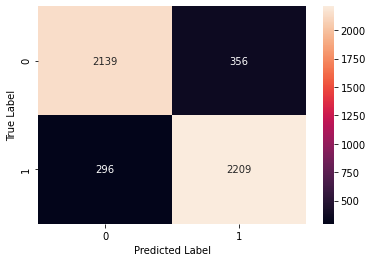

In [121]:
cm_xgb2 = confusion_matrix(test_df['label'], pred_labels_xgb2)

sns.heatmap(cm_xgb2, annot=True, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')